In [460]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Libraries

In [461]:
from utils.riskenv import RiskManagementEnvMultiTarget
from utils.common import (create_logger, get_dataset, predict_from_env, 
                          predict_from_frame, running_mean_last_n_samples, 
                          running_mean_per_class, plot_running_means_with_palette)
from utils.networks import ConvNetwork, FCNetwork, LSTMNetwork, GRUNetwork, GRUNetworkBidirectional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import TRPO, RecurrentPPO, QRDQN
from sklearn.preprocessing import MinMaxScaler, Normalizer
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from sklearn.metrics import (f1_score, recall_score, precision_score,
                            accuracy_score, mean_squared_error, 
                            r2_score, balanced_accuracy_score)
import warnings
warnings.filterwarnings("ignore")


# Dataset

In [462]:
SEED=123

In [463]:
fpath = "../data/dataset_2/raw/train.csv"
df = pd.read_csv(fpath)
df_copy = df.copy()

In [464]:
# group labels or leave as is
df_copy["Credit_Score"] = df_copy["Credit_Score"].map({"Good": 0, "Standard":1, "Poor": 2})

In [465]:
for column in df_copy.columns:
    # Check if the column is of object type (categorical)
    if df_copy[column].dtype == 'object':
        # Encode the column values to numeric
        df_copy[column] = pd.factorize(df_copy[column])[0]

In [466]:
# show all NaN columns
dropcols = df_copy.isna().sum()[(df_copy.isna().sum() != 0)].index.tolist()
dropcols

['Monthly_Inhand_Salary', 'Num_Credit_Inquiries']

In [467]:
unique_clients = df_copy["Customer_ID"].unique()
default_col = "Credit_Score"
original_features = ['Age',
            'Occupation',
            'Annual_Income', 
            'Num_Bank_Accounts',
            'Num_Credit_Card', 
            'Interest_Rate', 
            'Num_of_Loan', 
            'Type_of_Loan',
       'Delay_from_due_date', 
       'Num_of_Delayed_Payment', 
       'Credit_Mix', 
       'Outstanding_Debt',
       'Credit_Utilization_Ratio', 
       'Credit_History_Age',
       'Payment_of_Min_Amount', 
       'Total_EMI_per_month',
       'Amount_invested_monthly', 
       'Payment_Behaviour', 
       'Monthly_Balance']

In [468]:
df_copy.Month.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [469]:
CUTOFF = 6 # out of time set
train = df_copy[df_copy["Month"] <= CUTOFF].copy()
test = df_copy[df_copy["Month"] > CUTOFF].copy()

In [470]:
SCALE = False
if SCALE:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train[features] = scaler.fit_transform(train[features])
    train[features] = train[features].clip(-1, 1)
    test[features] = scaler.transform(test[features])
    test[features] = test[features].clip(-1, 1)

In [471]:
train[default_col].value_counts()

Credit_Score
1    46689
2    25396
0    15415
Name: count, dtype: int64

In [472]:
train = train.sort_values(["Month", "Customer_ID"])
test = test.sort_values(["Month", "Customer_ID"])

In [473]:
train.set_index(["Month", "Customer_ID"], inplace=True)
test.set_index(["Month", "Customer_ID"], inplace=True)


In [474]:
train.drop(["ID", "Name", "SSN"], axis=1, inplace=True)
test.drop(["ID", "Name", "SSN"], axis=1, inplace=True)

In [475]:
train_subset = train.copy()

Credit_Score
1    1031
2     755
0     748
Name: count, dtype: int64
Credit_Score
1    0.406867
2    0.297948
0    0.295185
Name: proportion, dtype: float64
(2534, 23) 370 362


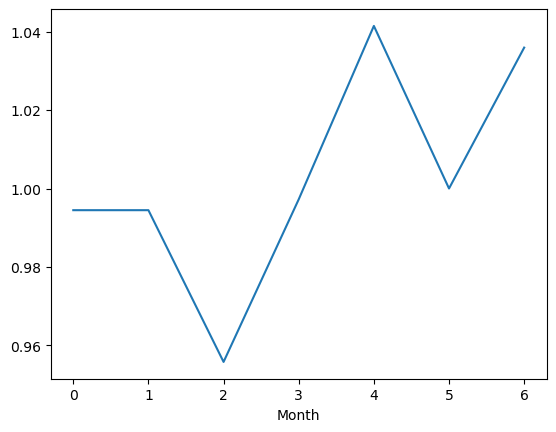

In [476]:
traindummy = train.reset_index()
dmy = []
for i in traindummy.Month.unique():
    a = traindummy[traindummy.Month == i].copy()
    b, c, d, e, f, g, h =  [], [], [] , [], [], [], []
    if i <=2:
        f = a[a[default_col] == 0].sample(40)["Customer_ID"].tolist()
        g = a[(a[default_col] == 2)].sample(20)["Customer_ID"].tolist()   
    if i > 2 and i <=4:
        b = a[a[default_col] == 1].sample(15)["Customer_ID"].tolist()
        c = a[a[default_col] == 0].sample(5)["Customer_ID"].tolist()
    if i > 3:
        d = a[a[default_col] == 2].sample(20)["Customer_ID"].tolist()
        e = a[a[default_col] == 1].sample(30)["Customer_ID"].tolist()

    dmy.append(b+c+d+e+f+g)
# dmy = [traindummy.sample(250).Customer_ID.tolist()]

# flatten list res
flat_list = [item for sublist in dmy for item in sublist]

train_subset = traindummy[traindummy["Customer_ID"].isin(flat_list)]
train_subset["Customer_ID"] = train_subset["Customer_ID"].replace(dict(zip(train_subset["Customer_ID"].unique(), 
                                                                         range(len(train_subset["Customer_ID"].unique())))))
train_subset.groupby('Month')[default_col].mean().plot()
train_subset = train_subset.set_index(["Month", "Customer_ID"])
print(train_subset[default_col].value_counts())
print(train_subset[default_col].value_counts(normalize=True))

print(train_subset.shape, len(flat_list), len(set(flat_list)))

test_copy = test.copy()
test_copy = test_copy.reset_index()
#sample N clients
dmy = [test_copy.sample(250).Customer_ID.tolist()]
flat_list = [item for sublist in dmy for item in sublist]

test_copy = test_copy[test_copy["Customer_ID"].isin(flat_list)]



# map date code to range from 0 to highest
test_copy['Customer_ID'] = test_copy['Customer_ID'].map(lambda x: x - test_copy['Customer_ID'].min())
test_copy['Month'] = test_copy['Month'].map(lambda x: x - test_copy['Month'].min())
test_copy.set_index(["Month", "Customer_ID"], inplace=True)


In [477]:
FEATURE_EXPANSION = True
if FEATURE_EXPANSION:
    n_components = 200
    rbf_feature = RBFSampler(gamma=1, n_components=n_components,random_state=SEED)
    features = [f"x_{x}" for x in range(n_components)]
    train_transformed = pd.DataFrame(rbf_feature.fit_transform(train_subset[original_features]), columns=features)
    train_subset = train_subset[[default_col]].reset_index().merge(train_transformed, left_index=True, right_index=True)
    train_subset = train_subset.set_index(["Month", "Customer_ID"])


In [478]:
SCALE = True
if SCALE:
    scaler = MinMaxScaler((-1, 1))
    train_subset[features] = scaler.fit_transform(train_subset[features])
    train_subset[features] = train_subset[features].clip(-1, 1)

# Check Environment

In [479]:
LEARNING_STEPS = len(train_subset)
print(LEARNING_STEPS)
CustomEnv = RiskManagementEnvMultiTarget
# Define environment configuration
kwargs = {
    'features_col': features, # feature colums
    'default_col': default_col, # default column
    'obs_dim': len(features),
    'action_dim' : 3, 
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}


check_env(CustomEnv(train_subset, debug=True, scaled_features=SCALE, accepts_discrete_action=True, seed=SEED, **kwargs), warn=True)

2534
reward: 0.00000 - Client: 214 -Action: 2 - Default: 1.0 - client:   0
reward: 0.50000 - Client: 79 -Action: 2 - Default: 1.0 - client:   1
reward: -0.50000 - Client: 66 -Action: 2 - Default: 1.0 - client:   3
reward: -0.50000 - Client: 63 -Action: 2 - Default: 0.0 - client:   5
reward: 0.00000 - Client: 163 -Action: 1 - Default: 0.0 - client:   0
reward: -0.50000 - Client: 162 -Action: 0 - Default: 1.0 - client:   2


# DQN

In [480]:
kwargs = {
    'features_col': features, # feature colums
    'default_col': default_col, # default column
    'obs_dim': len(features),
    'action_dim' : 3,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}

num_envs = 1
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)
log_path = "logs/multiclass/dqn"  # Specify your log directory
logger = create_logger(log_path)

In [481]:
feature_extractor = FCNetwork
# Now use the custom network in policy_kwargs
policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=400,
                                   first_layer_dropout=0.3,
                                   output_layer=400,
                                   output_layer_dropout=0.1)
)


model_dqn = DQN("MlpPolicy", 
                training_env, 
                verbose=1, 
                device="cpu",
                seed=SEED,
                learning_rate=1e-3, 
                gamma=0.9, 
                policy_kwargs=policy_kwargs,
                buffer_size=1_000_000, 
                learning_starts=100, 
                batch_size=64-6, 
                tau=0.8, 
                train_freq=2
                )
model_dqn.set_logger(logger)
model_dqn.learn(LEARNING_STEPS*2,log_interval=1)
model_dqn.save("output/multiclass/dqn")

Using cpu device
reward: 0.00000 - Client: 247 -Action: 0 - Default: 2.0 - client:   0
reward: -0.50000 - Client: 19 -Action: 1 - Default: 0.0 - client:   2
reward: 0.50000 - Client: 79 -Action: 2 - Default: 1.0 - client:   4
reward: 0.50000 - Client: 66 -Action: 0 - Default: 1.0 - client:   6
reward: -0.50000 - Client: 125 -Action: 1 - Default: 1.0 - client:   1
reward: -0.50000 - Client: 163 -Action: 1 - Default: 0.0 - client:   3
reward: 0.50000 - Client: 162 -Action: 1 - Default: 2.0 - client:   5
reward: 0.00000 - Client: 296 -Action: 1 - Default: 0.0 - client:   0
reward: -0.50000 - Client: 322 -Action: 2 - Default: 0.0 - client:   2
reward: -0.50000 - Client: 185 -Action: 2 - Default: 0.0 - client:   4
reward: -0.50000 - Client: 88 -Action: 0 - Default: 2.0 - client:   6
reward: -0.50000 - Client: 286 -Action: 0 - Default: 2.0 - client:   1
reward: 0.50000 - Client: 148 -Action: 0 - Default: 1.0 - client:   3
reward: -0.50000 - Client: 53 -Action: 2 - Default: 1.0 - client:   5


In [482]:
# Define environment configuration
n_steps = len(train_subset)
rew_dqn, act_dqn = predict_from_env(model_dqn, training_env, n_steps)
act_dqn_b, date_codes = predict_from_frame(model_dqn, train_subset[features])

reward: 0.00000 - Client: 41 -Action: 2 - Default: 1.0 - client:   0
action: [2] - reward : [-0.5] - done: [False]
reward: -0.50000 - Client: 244 -Action: 1 - Default: 1.0 - client:   2
reward: 0.50000 - Client: 244 -Action: 1 - Default: 1.0 - client:   4
reward: -0.50000 - Client: 75 -Action: 2 - Default: 2.0 - client:   6
reward: 0.50000 - Client: 113 -Action: 0 - Default: 0.0 - client:   1
reward: 0.50000 - Client: 1 -Action: 2 - Default: 2.0 - client:   3
reward: -0.50000 - Client: 97 -Action: 1 - Default: 1.0 - client:   5
reward: 0.00000 - Client: 219 -Action: 1 - Default: 1.0 - client:   0
reward: 0.50000 - Client: 94 -Action: 0 - Default: 0.0 - client:   2
reward: 0.50000 - Client: 116 -Action: 0 - Default: 0.0 - client:   4
reward: 0.50000 - Client: 264 -Action: 1 - Default: 1.0 - client:   6
reward: -0.50000 - Client: 214 -Action: 1 - Default: 1.0 - client:   1
reward: 0.50000 - Client: 274 -Action: 1 - Default: 1.0 - client:   3
reward: 0.50000 - Client: 66 -Action: 1 - Defa

Text(0.5, 1.0, 'RMSE : 0.0272268165914133 - R2 : -0.04294478527607137')

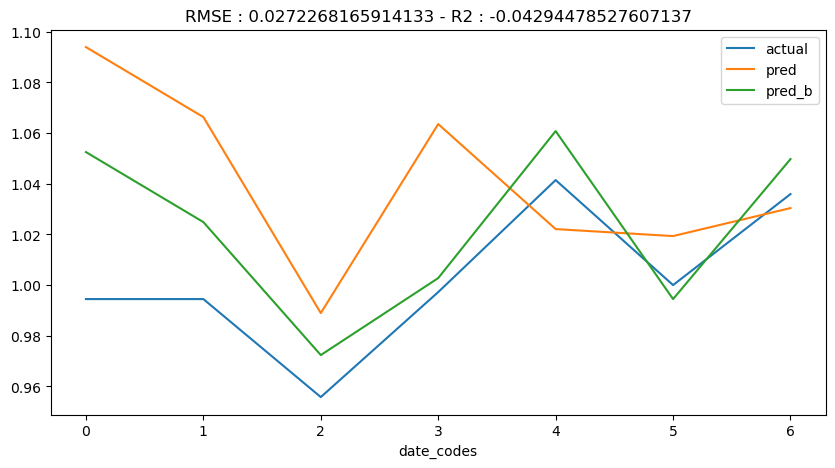

In [491]:
res = pd.DataFrame({"date_codes":date_codes,
              "actual":train_subset[default_col],
              "pred":act_dqn,
              "pred_b":act_dqn_b
              }).groupby("date_codes").mean()

ax = res.plot(figsize=(10, 5))
# set title for the plot
ax.set_title(f"RMSE : {np.sqrt(mean_squared_error(res.actual, res.pred_b))} - R2 : {r2_score(res.actual, res.pred_b)}")

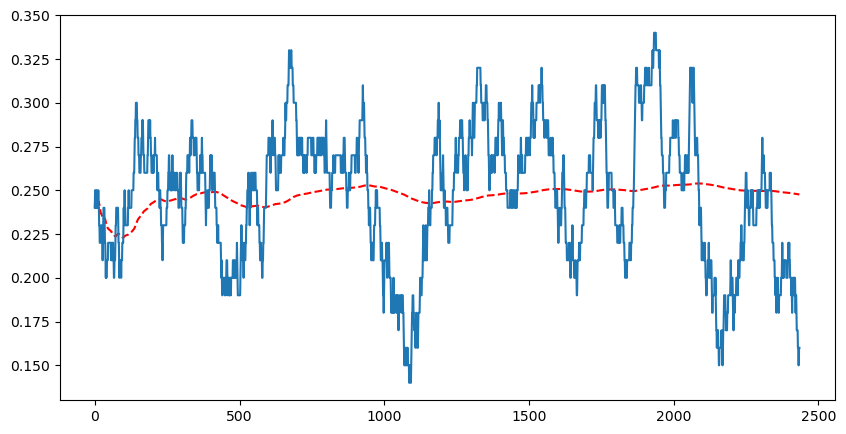

In [492]:
run_mean_rew_dqn = running_mean_last_n_samples(rew_dqn, 100)
plt.figure(figsize=(10, 5))
plt.plot((np.cumsum(run_mean_rew_dqn)/np.arange(1, len(run_mean_rew_dqn)+1)) , color="red", linestyle="dashed")
plt.plot(run_mean_rew_dqn)

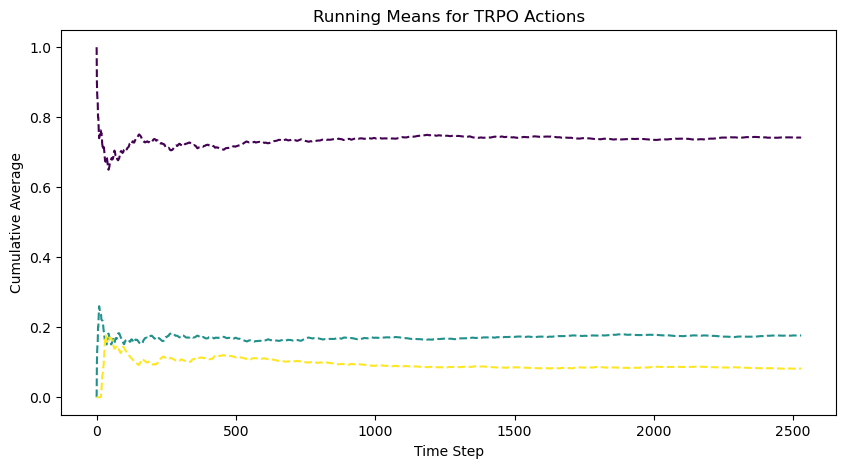

In [493]:
err_dqn = np.sqrt((train_subset[default_col]-act_dqn_b)**2)
running_means_act_dqn = running_mean_per_class(err_dqn, 5, len(set(act_dqn)))
# running_means_act_dqn_b = running_mean_per_class(train_subset[default_col], 5, len(set(act_dqn_b)))

# Example usage:
plt.figure(figsize=(10, 5))  # Create a figure outside the function calls
plot_running_means_with_palette(running_means_act_dqn, title='Running Means for TRPO Actions', show_legend=False)
# plot_running_means_with_palette(running_means_act_dqn_b, title='Running Means for TRPO Actions B')
plt.show()  # Show the plot after all function calls


In [494]:
# [True Negative ,False Negative]
# [​False Positive, True Positive]
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_dqn_b), columns=["0", "1", "2"], index=["0", "1", "2"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_dqn_b))


------------------------------
     0    1    2
0  524  111  113
1   83  829  119
2   95  133  527
------------------------------
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       748
           1       0.77      0.80      0.79      1031
           2       0.69      0.70      0.70       755

    accuracy                           0.74      2534
   macro avg       0.74      0.73      0.74      2534
weighted avg       0.74      0.74      0.74      2534



# A2C

In [ ]:
kwargs = {
    'features_col': features, # feature colums
    'default_col': default_col, # default column
    'obs_dim': len(features),
    'action_dim' : 3,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}

num_envs = 1
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)
log_path = "logs/multiclass/a2c"  # Specify your log directory
logger = create_logger(log_path)

In [ ]:
feature_extractor = FCNetwork
# Now use the custom network in policy_kwargs
policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=100,
                                   first_layer_dropout=0.1,
                                   output_layer=80,
                                   output_layer_dropout=0.1)
)
model_a2c = A2C("MlpPolicy", 
                training_env, 
                verbose=0, 
                device="cpu", 
                learning_rate=1e-3, 
                gamma=0.9, 
                seed=SEED,
                n_steps= 128,
                policy_kwargs=policy_kwargs
                )

model_a2c.set_logger(logger)
model_a2c.learn(LEARNING_STEPS*2, log_interval=1)
model_a2c.save("output/multiclass/a2c")

In [ ]:
n_steps = len(train_subset)
rew_a2c, act_a2c = predict_from_env(model_a2c, pred_env, n_steps)
act_a2c_b, date_codes = predict_from_frame(model_a2c, train_subset[features])

In [ ]:
run_mean_rew_a2c= running_mean_last_n_samples(rew_a2c, 100)
plt.figure(figsize=(10, 5))
plt.plot((np.cumsum(run_mean_rew_a2c)/np.arange(1, len(run_mean_rew_a2c)+1)) , color="red", linestyle="dashed")
plt.plot(run_mean_rew_a2c)

In [ ]:
res = pd.DataFrame({"date_codes":date_codes,
              "actual":train_subset[default_col],
              "pred":act_a2c,
              "pred_b":act_a2c_b,
              "reward":np.append(run_mean_rew_a2c, np.zeros(99))
              }).groupby("date_codes").mean()
rew = res.reward
res = res.drop("reward", axis=1)
ax = res.plot(figsize=(10, 5))
# set title for the plot
ax.set_title(f"RMSE : {np.sqrt(mean_squared_error(res.actual, res.pred))} - R2 : {r2_score(res.actual, res.pred_b)}")
# plt.plot(rew, color="red", linestyle=":", label="Reward")
plt.legend()

In [ ]:
run_mean_act_a2c = running_mean_last_n_samples(act_a2c, 10)
run_mean_act_a2c_b = running_mean_last_n_samples(act_a2c_b, 10)
# moving average of rew_dqn
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(run_mean_act_a2c)/(np.arange(1,len(run_mean_act_a2c)+1)) , color="red", linestyle="dashed")
plt.plot(np.cumsum(run_mean_act_a2c_b)/(np.arange(1,len(run_mean_act_a2c_b)+1)) , color="blue", linestyle=":")


In [ ]:
from sklearn.metrics import confusion_matrix
# [True Negative ,False Negative]
# [​False Positive, True Positive]
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_a2c), columns=["0", "1","2"], index=["0", "1","2"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_a2c_b))

# PPO

In [ ]:
kwargs = {
    'features_col': features, # feature colums
    'default_col': default_col, # default column
    'obs_dim': len(features),
    'action_dim' : 3,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}

num_envs = 1
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)
log_path = "logs/multiclass/ppo"  # Specify your log directory
logger = create_logger(log_path)

In [ ]:
feature_extractor = FCNetwork
# Now use the custom network in policy_kwargs
policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=300,
                                   first_layer_dropout=0.2,
                                   output_layer=100,
                                   output_layer_dropout=0.1)
)

model_ppo = PPO("MlpPolicy", 
                training_env, 
                verbose=0, 
                device="cpu",
                learning_rate=1e-3, 
                gamma=0.9, 
                seed=SEED,
                batch_size=64, 
                n_steps=1024, 
                policy_kwargs=policy_kwargs
                )

model_ppo.set_logger(logger)
model_ppo.learn(LEARNING_STEPS,log_interval=1)
model_ppo.save("output/multiclass/ppo")

In [ ]:
n_steps = len(train_subset)
rew_ppo, act_ppo = predict_from_env(model_ppo, pred_env, n_steps)

In [ ]:
act_ppo_b, date_codes = predict_from_frame(model_ppo, train_subset[features])

res = pd.DataFrame({"date_codes":date_codes,
              "actual":train_subset[default_col],
              "pred":act_ppo,
              "pred_b":act_ppo_b
              }).groupby("date_codes").mean()

ax = res.plot(figsize=(10, 5))
# set title for the plot
ax.set_title(f"RMSE : {np.sqrt(mean_squared_error(res.actual, res.pred))} - R2 : {r2_score(res.actual, res.pred)}")

In [ ]:
run_mean_rew_ppo = running_mean_last_n_samples(rew_ppo, 100)
plt.figure(figsize=(10, 5))
plt.plot((np.cumsum(run_mean_rew_ppo)/np.arange(1, len(run_mean_rew_ppo)+1)) , color="red", linestyle="dashed")
plt.plot(run_mean_rew_ppo)

In [ ]:
run_mean_act_ppo = running_mean_last_n_samples(act_ppo, 10)
run_mean_act_ppo_b = running_mean_last_n_samples(act_ppo_b, 10)
# moving average of rew_dqn
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(run_mean_act_ppo)/(np.arange(1,len(run_mean_act_ppo)+1)) , color="red", linestyle="dashed")
plt.plot(np.cumsum(run_mean_act_ppo_b)/(np.arange(1,len(run_mean_act_ppo_b)+1)) , color="blue", linestyle=":")

In [ ]:
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_ppo), columns=["0", "1","2"], index=["0", "1","2"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_ppo))

# Gradient Boosting (Baseline)

In [490]:
model_gb = HistGradientBoostingClassifier()
model_gb.fit(train_subset[features], train_subset[default_col])
act_gb = model_gb.predict(train_subset[features])
print(classification_report(train_subset[default_col], act_gb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       748
           1       1.00      1.00      1.00      1031
           2       1.00      1.00      1.00       755

    accuracy                           1.00      2534
   macro avg       1.00      1.00      1.00      2534
weighted avg       1.00      1.00      1.00      2534



# Compare

In [ ]:
res = pd.DataFrame({"date_codes":date_codes,
              "actual": train_subset[default_col],
              "rppo":act_rppo,
              "ppo":act_ppo,
              "trpo":act_trpo,
              "dqn":act_dqn,
              "a2c":act_a2c,
              "gb":act_gb
              }).groupby("date_codes").mean()

ax = res.plot(figsize=(10, 5),)
# upported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.lines[0].set_linestyle("-")  # actual line
ax.lines[1].set_linestyle(":")  # rppo line
ax.lines[2].set_linestyle(":")  # ppo line
ax.lines[3].set_linestyle(":")  # trpo line
ax.lines[4].set_linestyle(":")  # dqn line
ax.lines[5].set_linestyle(":")  # a2c line
ax.lines[5].set_linestyle(":")  # gb line
# set legend with RMSE values computed for each graph

# set title for the plot
# ax.set_title(f"RMSE : {np.sqrt(mean_squared_error(res.actual, res.pred))} - R2 : {r2_score(res.actual, res.pred)}")

In [ ]:
resb = pd.DataFrame({"date_codes":date_codes,
              "actual": train_subset[default_col],
              "rppo":act_rppo_b,
              "ppo":act_ppo_b,
              "trpo":act_trpo_b,
              "dqn":act_dqn_b,
              "a2c":act_a2c_b,
              "gb":act_gb
              }).groupby("date_codes").mean()

ax1 = resb.plot(figsize=(10, 5),)
# upported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax1.lines[0].set_linestyle("-")  # actual line
ax1.lines[1].set_linestyle(":")  # rppo line
ax1.lines[2].set_linestyle(":")  # ppo line
ax1.lines[3].set_linestyle(":")  # trpo line
ax1.lines[4].set_linestyle(":")  # dqn line
ax1.lines[5].set_linestyle(":")  # a2c line
ax1.lines[6].set_linestyle(":")  # gb line
# set legend with RMSE values computed for each graph
ax.legend(["Actual", "rppo", "ppo", "trpo", "dqn", "a2c", "gb"], loc="upper right")

# set title for the plot
# ax.set_title(f"RMSE : {np.sqrt(mean_squared_error(res.actual, res.pred))} - R2 : {r2_score(res.actual, res.pred)}")

In [ ]:
# plot vivolin plot using seaborn for all models in resb
sns.violinplot(data=res, alpha=0.5, palette="pastel")
# plot violinplot of res with transparency and custom color palette using seaborn
sns.violinplot(data=resb, alpha=0.5, palette="pastel")

In [ ]:
errb = res - resb
sns.violinplot(data=errb, alpha=0.5, palette="pastel")

In [ ]:
# subtract res["actual"] from all columns in dataframe res
res.subtract(res["actual"], axis=0).plot()

In [ ]:
sns.violinplot(data=res.subtract(res["actual"], axis=0), alpha=0.5, palette="pastel")
sns.violinplot(data=resb.subtract(resb["actual"], axis=0), alpha=0.5, palette="pastel")

# Generalization

In [ ]:

# Define environment configuration
kwargs = {
    'features_col': features,
    'default_col': 'default_120_12m',
    'obs_dim': len(features),
    'action_dim' : 3,
    'client_dim': len(test_selected.loc[0].index.unique()), # number of clients
    'model_name': "test"
}
n_steps = len(test_selected)

In [ ]:
from joblib import Parallel, delayed

# Define a wrapper function for predict_from_env
def run_prediction(model, data):
    return predict_from_frame(model, data)

# List of models to run predictions on
models = [model_trpo, model_dqn, model_qrdqn, model_ppo, model_a2c, model_rppo]

# Running predictions in parallel
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_prediction)(model, test_selected) for model in models
)

# Unpacking results
test_trpo_rew, test_trpo_act = results[0]
test_dqn_rew, test_dqn_act = results[1]
test_qrdqn_rew, test_qrdqn_act = results[2]
test_ppo_rew, test_ppo_act = results[3]
test_a2c_rew, test_a2c_act = results[4]
test_rppo_rew, test_rppo_act = results[5]

In [ ]:
test_trpo_rew, test_trpo_act = predict_from_env(model_trpo, test_env, test_selected)
test_dqn_rew, test_dqn_act = predict_from_env(model_dqn, test_env, test_selected)
test_ppo_rew, test_ppo_act = predict_from_env(model_ppo, test_env, test_selected)
test_a2c_rew, test_a2c_act = predict_from_env(model_a2c, test_env, test_selected) 
test_rppo_rew, test_rppo_act = predict_from_env(model_rppo, test_env, test_selected)

In [ ]:
plt.plot(np.cumsum(test_trpo_rew)/np.arange(1, len(test_trpo_rew)+1) , color="red", linestyle=":")
plt.plot(np.cumsum(test_dqn_rew)/np.arange(1, len(test_dqn_rew)+1) , color="blue", linestyle=":")
plt.plot(np.cumsum(test_ppo_rew)/np.arange(1, len(test_ppo_rew)+1) , color="green", linestyle=":")
plt.plot(np.cumsum(test_rppo_rew)/np.arange(1, len(test_a2c_rew)+1) , color="black", linestyle=":")
plt.plot(np.cumsum(test_a2c_rew)/np.arange(1, len(test_a2c_rew)+1) , color="orange", linestyle=":")



In [ ]:
plt.plot(test_trpo_rew, color="red", linestyle=":")
plt.plot(test_dqn_rew, color="blue", linestyle=":")
plt.plot(test_ppo_rew, color="green", linestyle=":")
plt.plot(test_rppo_rew, color="green", linestyle=":")
plt.plot(test_a2c_rew, color="orange", linestyle=":")

In [ ]:
# print classification report for all test_rew
print("-"*30, "test_dqn_act", "-"*30)
print(classification_report(test_selected[default_col].values, test_dqn_act))
print("-"*30, "test_ppo_act", "-"*30)
print(classification_report(test_selected[default_col].values, test_ppo_act))
print("-"*30, "test_a2c_act", "-"*30)
print(classification_report(test_selected[default_col].values, test_a2c_act))
print("-"*30, "test_trpo_act", "-"*30)
print(classification_report(test_selected[default_col].values, test_trpo_act))
print("-"*30, "test_rppo_act", "-"*30)
print(classification_report(test_selected[default_col].values, test_rppo_act))
print("-"*30, "test_gb_preds", "-"*30)
test_gb_preds = model_gb.predict(test_selected[features])
print(classification_report(test_selected[default_col].values,test_gb_preds))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have a list of model predictions called 'model_predictions'
# and a list of true labels called 'true_labels'
model_predictions = [test_trpo_act, test_dqn_act, test_ppo_act, test_a2c_act, test_rppo_act, test_gb_preds]
# Iterate over each model's predictions and true labels
for i in range(len(model_predictions)):
    fpr, tpr, _ = roc_curve(test_copy[default_col].values, model_predictions[i])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, label=f"Model {i+1} (AUC = {roc_auc:.2f})")

# Set labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()